In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('src/')

eps=1e-8

from main import *
from utils import *

In [2]:
import hdf5storage

file=hdf5storage.loadmat('../school_splits/school_b.mat')
X=file.get('x')
y=file.get('y')


file1=hdf5storage.loadmat('../school_splits/school_1_indexes.mat')
train_ix=file1.get('tr').reshape(-1)-1
test_ix=file1.get('tst').reshape(-1)-1
tr_tsk_ix=file1.get('tr_indexes').reshape(-1)-1
ts_tsk_ix=file1.get('tst_indexes').reshape(-1)-1


x_train=X[:,train_ix]
y_train=y[train_ix]

x_test=X[:,test_ix]
y_test=y[test_ix]
Dini=np.eye(len(x_train))/len(x_train)

In [3]:
%%time

testerrs,theW,theD,mineps=run_code_example(1,x_train,y_train,x_test,y_test,
                 tr_tsk_ix,ts_tsk_ix,
                 0,Dini,5,'feat', 1e-4,'')

CPU times: user 14.3 s, sys: 428 ms, total: 14.8 s
Wall time: 4.07 s


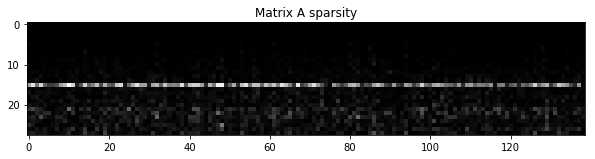

In [4]:
theU=np.linalg.eig(theD)[1]
theA=np.dot(theU.T,theW)

plt.figure(figsize=(10,6))
plt.imshow(abs(theA),cmap='gray')
plt.title('Matrix A sparsity')
plt.show()